# Some important Imports

In [1]:
import pandas as pd # pandas for dataframes
import numpy as np # numpy for math
from sklearn.model_selection import train_test_split # train_test_split
import matplotlib.pyplot as plt   # matplotlib for plotting
from keras.preprocessing.text import Tokenizer # Tokenizer
from keras.preprocessing.sequence import pad_sequences # pad_sequences
from keras.callbacks import EarlyStopping # EarlyStopping
from keras.models import Sequential # Sequential 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D # Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import load_model # load_model

# Importing clean data from csv 

In [2]:
print(" \nImporting Cleaned Training data(train_clean.csv) from data folder\n ")

# Reading the training and testing dataset
df_data = pd.read_csv('./data/train_clean.csv')
# df_data= pd.read_csv('./test/clean5.csv')
#convert abstract column to str
df_data['abstract'] = df_data['abstract'].astype(str)
print('First five Rows of Cleaned Train data \n \n ',df_data.head()) 



,id,abstract,category,category_num
0,271675,bacteria often expos multipl stimuli complex e...,q-bio-QM,138
1,412276,accur knowledg thermodynam properti zero tempe...,hep-ph-,68
2,256956,largest solar flare solar cycl preced flare oc...,astro-ph-SR,7
3,427612,say random integ variabl monoton modulus char...,math-PR,93
4,113852,deriv formula express joint distribut cyclic v...,math-CO,76


## Memory Saving

In [3]:
# convert "category " column to Categorial data to save memory space as they are repeated and in fixed no.


df_data['category'] = df_data['category'].astype('category')

# convert "id " and "category_num" column to int32 to save memory space as they are repeaded and in fixed no.
df_data[['id','category_num']] = df_data[['id','category_num']].astype('int32')

df_data.memory_usage(deep=True)

# hence sucessfully reduced memory size of "category" column from 25487734 bytes to  795575 bytes and id and category_num column from 3.4 mb to 1.5 mb

Index                 128
id                1562412
abstract        274227007
category           795575
category_num      1562412
dtype: int64

# Prepare the data for training

In [4]:

# # The maximum number of words to be used. (most frequent)
MAX_NB_WORDS =50000
# Max number of words in each abstract
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,oov_token = '<UNK>') 


## Tokenize

In [5]:
tokenizer.fit_on_texts(df_data.abstract) # fit the tokenizer on the abstracts
word_index = tokenizer.word_index
word_counts= tokenizer.word_counts
print('Found %s unique tokens.' % len(word_index))

Found 165017 unique tokens.


### create wordindex.csv , wordcounts.csv and train_clean_counts_words  

In [ ]:
counts=df_data['abstract'].apply(lambda x: len(str(x).split(' ')))
df_train_clean_counts_word= df_data.copy()
df_train_clean_counts_word['counts_word']=counts

#save to csv
df_train_clean_counts_word.to_csv('train_clean_counts_word.csv',index=False)
print('Analyze train_clean_counts_word.csv in root to determine suitable value for MAX_SEQUENCE_LENGTH \n \n ')

In [ ]:
#convert dictionary to dataframe
df_word_index=pd.DataFrame.from_dict(word_index, orient='index')
df_word_index.reset_index(inplace=True)
df_word_index.columns=['word','index_number']
#save to csv
df_word_index.to_csv('word_index.csv',index=False)

print('Analyze word_index.csv in root folder to view index number assigned to each word \n \n ')

#convert wordcount ordered dictionary to dataframe
df_word_counts=pd.DataFrame.from_dict(word_counts, orient='index')
df_word_counts.reset_index(inplace=True)
df_word_counts.columns=['word','counts']
#save to csv
df_word_counts.to_csv('word_counts.csv',index=False)

print('Analyze word_counts.csv in root folder to view the number of times a word is repeated and determine the dictionary length MAX_NB_WORDS \n \n ')

In [6]:

X = tokenizer.texts_to_sequences(df_data.abstract)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

type(X)

Shape of data tensor: (390603, 200)


numpy.ndarray

In [7]:

Y = pd.get_dummies(df_data['category_num']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (390603, 156)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(351542, 200) (351542, 156)
(39061, 200) (39061, 156)


# Model  and Train it

## Model

In [10]:
EMBEDDING_DIM = 200
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1],trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(Y[1]), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
epochs = 50
batch_size= 512

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          10000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 156)               31356     
Total params: 10,352,156
Trainable params: 10,352,156
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [13]:
# train the model  on the whole training set with early stopping 
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]) 

Epoch 1/50
618/618 [==============================] - 1769s 3s/step - loss: 3.0356 - accuracy: 0.2579 - val_loss: 2.0108 - val_accuracy: 0.4531
Epoch 2/50
618/618 [==============================] - 1133s 2s/step - loss: 1.7004 - accuracy: 0.5283 - val_loss: 1.4480 - val_accuracy: 0.5841
Epoch 3/50
618/618 [==============================] - 1059s 2s/step - loss: 1.3073 - accuracy: 0.6207 - val_loss: 1.2720 - val_accuracy: 0.6226
Epoch 4/50
618/618 [==============================] - 1842s 3s/step - loss: 1.1241 - accuracy: 0.6656 - val_loss: 1.2049 - val_accuracy: 0.6414
Epoch 5/50
618/618 [==============================] - 969s 2s/step - loss: 0.9989 - accuracy: 0.6979 - val_loss: 1.1954 - val_accuracy: 0.6460
Epoch 6/50
618/618 [==============================] - 952s 2s/step - loss: 0.8983 - accuracy: 0.7263 - val_loss: 1.2051 - val_accuracy: 0.6463
Epoch 7/50
618/618 [==============================] - 924s 1s/step - loss: 0.8148 - accuracy: 0.7491 - val_loss: 1.2301 - val_accuracy: 0.

## Save model and import it 

In [16]:
# save trained model to disk
model.save('./Saved_model/model.h5')

## Test accuracy 

In [17]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1221/1221 [==============================] - 129s 105ms/step - loss: 1.3058 - accuracy: 0.6367
Test set
  Loss: 1.306
  Accuracy: 0.637


# Plot

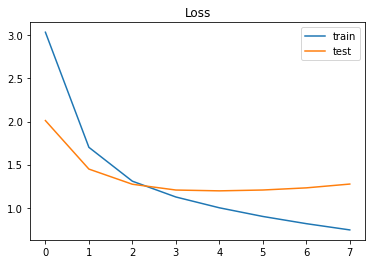

In [18]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

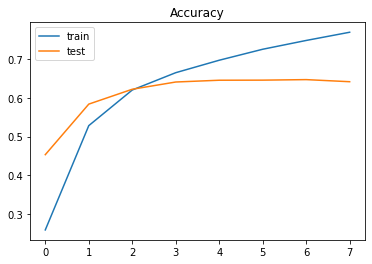

In [19]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();